<a href="https://colab.research.google.com/github/babazibidi/pdfreading/blob/main/Amazon_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Relevant Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [5]:
df = pd.read_excel('/content/amazon.xlsx')

In [6]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


Normalizing Case Folding

In [7]:
df['Review'] = df['Review'].str.lower()

Punctuations

In [14]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex = True)

Numbers

In [16]:
df['Review'] = df['Review'].str.replace('\d', '', regex = True)

Stopwords

In [17]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x.lower() not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df['Review']

,Review
0,happy
1,good quality material however panels mismatched
2,product fun bedroom windowsbr imagery bit stretched still funbr material lightweight sheer appreciate
3,lo unico que gustaria es que sean un poco mas largas
4,great bang buck cant believe quality material vibrant colors eclectic style works beautifully ties together
5,looks different photo
6,exactly looking heavy material great price ships fast
7,looking picture thought curtains would thinner sheer nice thickness weight help insulate front window look absolutely perfect arrived quickly pleased purchase
8,much whiter thought would wasnt really expecting wanting use
9,curtains picture shows rd set ambesonne curtains one set use spring summer one autumn set christmas winter durable colors vibrant recommend curtains


Rarewords / Custom Words

In [20]:
sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

Lemmatization

In [22]:
nltk.download('wordnet')
from textblob import Word
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
df['Review'].head(10)

,Review
0,happy
1,good quality material however panel mismatched
2,product fun bedroom windowsbr imagery bit stretched still funbr material lightweight sheer appreciate
3,lo unico que gustaria e que sean un poco ma largas
4,great bang buck cant believe quality material vibrant color eclectic style work beautifully tie together
5,look different photo
6,exactly looking heavy material great price ship fast
7,looking picture thought curtain would thinner sheer nice thickness weight help insulate front window look absolutely perfect arrived quickly pleased purchase
8,much whiter thought would wasnt really expecting wanting use
9,curtain picture show rd set ambesonne curtain one set use spring summer one autumn set christmas winter durable color vibrant recommend curtain


Text Visualization

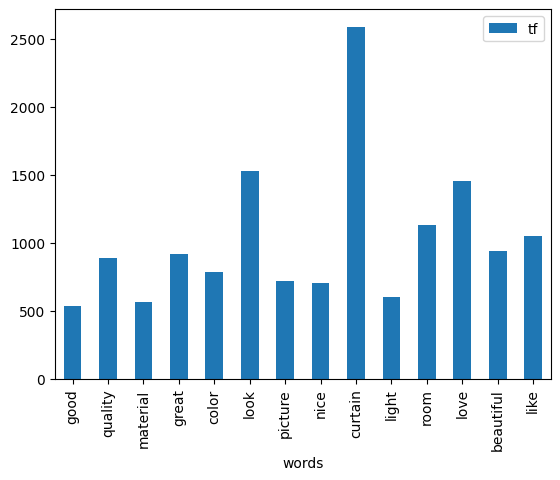

In [26]:
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']
tf[tf['tf']>500].plot.bar(x='words', y='tf')
plt.show()

Wordcloud

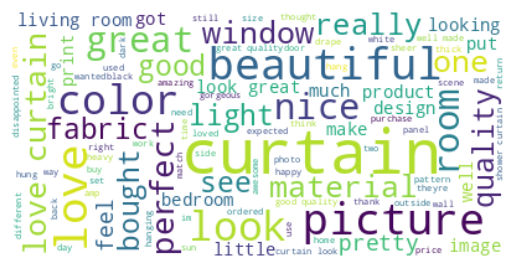

In [27]:
text = " ".join(i for i in df.Review)
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color = 'white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Setiment Analysis

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [32]:
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x))
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])
df['Review'][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Setiment_Label"] = df['Review'].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.groupby("Setiment_Label")['Star'].mean()

,Star
Setiment_Label,
neg,3.40
pos,4.58


In [33]:
df.head()

,Star,HelpFul,Title,Review,Setiment_Label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,pos


Machine Learning

In [34]:
train_x, test_x, train_y, test_y = train_test_split(df['Review'],
                                                    df['Setiment_Label'],
                                                    random_state = 17)

In [ ]:
# In order to provide data to the machine learning model, we need to convert the representations into numerical data.

TF-IDF Word Level

In [38]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

Modelling

In [39]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [40]:
y_pred = log_model.predict(x_test_tf_idf_word)

In [41]:
classification_report(y_pred, test_y)

'              precision    recall  f1-score   support\n\n         neg       0.24      0.91      0.38        56\n         pos       1.00      0.88      0.94      1347\n\n    accuracy                           0.88      1403\n   macro avg       0.62      0.90      0.66      1403\nweighted avg       0.97      0.88      0.91      1403\n'

Random Forest

In [42]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8852440264361974